Connected to Python 3.12.1

In [ ]:
#imports werent working
df_improved = final_df.copy()


for col in df_improved.select_dtypes(include=['float', 'int']).columns:
    df_improved[col] = df_improved[col].replace([np.inf, -np.inf], np.nan)
    df_improved[col] = df_improved[col].fillna(df_improved[col].median())

#  Engineer new features (focusing on the most important ones)
# Log transformations
for col in ['GDP_3m_avg', 'Exchange_rate_USD_3m_avg', '10_year_gilt_yield_3m_avg']:
    df_improved[f'log_{col}'] = np.log(df_improved[col].clip(lower=0.001))

# Percentage change
for col in ['GDP_3m_avg', 'CPIH_3m_avg']:
    df_improved[f'{col}_change'] = df_improved[col].pct_change().fillna(0).clip(-1, 1)

# Prepare data - use BOTH binary and original classes
# Original features
features = ['GDP_3m_avg', 'Exchange_rate_USD_3m_avg', '10_year_gilt_yield_3m_avg', 
            'Unemployment_rate_3m_avg', 'CPIH_3m_avg', 'CCI_3m_avg',
            'log_GDP_3m_avg', 'log_Exchange_rate_USD_3m_avg', 'log_10_year_gilt_yield_3m_avg',
            'GDP_3m_avg_change', 'CPIH_3m_avg_change']

# Use a 50/50 split to have more balanced classes in training
X = df_improved[features]
y = df_improved['rate_change']  # Use original multiclass target

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Split 50/50 instead of 70/30
split_point = int(0.5 * len(X_scaled_df))
X_train, X_test = X_scaled_df[:split_point], X_scaled_df[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# Train a simple model with class balancing
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

model.fit(X_train, y_train)

#  Evaluate
y_pred = model.predict(X_test)

print("Improved Model Results:")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#Show feature importance
importances = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head(5))

NameError: name 'final_df' is not defined

In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve, 
    roc_auc_score, 
    precision_recall_curve, 
    average_precision_score,
    confusion_matrix, 
    classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

In [ ]:
#Data loaded to yuan
yuan = pd.read_stata("Data/yuan_inflation_data.dta")

#data exploration
print("Dataset information:")
print(yuan.info())

#first 10 rows with a parapgraph break to get a clear viewing of the data
print("\nFirst few rows:")
print(yuan.head(10))


#.descibe to get summary statistics 
print("\nBasic statistics:")
print(yuan.describe())

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   year         96 non-null     int16  
 1   emperor      96 non-null     int8   
 2   emperorname  96 non-null     object 
 3   disaster     96 non-null     int8   
 4   nomgrants    96 non-null     int32  
 5   external     96 non-null     int8   
 6   unification  96 non-null     int8   
 7   rebellion    96 non-null     int8   
 8   nominal      96 non-null     int32  
 9   totalwar     96 non-null     int8   
 10  pop          96 non-null     float64
 11  cpi          96 non-null     float32
dtypes: float32(1), float64(1), int16(1), int32(2), int8(6), object(1)
memory usage: 3.5+ KB
None

First few rows:
   year  emperor emperorname  disaster  nomgrants  external  unification  \
0  1260        1       shizu         1     120755         0            1   
1  1261        1     

In [ ]:
#create a new df with the year and totalwar 
top_wars = yuan[['year', 'totalwar']]
#sort the dataframe by the totalwar column in descending order 
top_wars = top_wars.sort_values(by='totalwar', ascending=False).head(10)


#same thing for nominal money issues
top10_nominal_money = yuan[['year', 'nominal']]
top10_nominal_money = top10_nominal_money.sort_values(by='nominal', ascending=False).head(10)

#I wont print as I will put the output in markdown format for analysis

In [ ]:
overlapping_years = set(top_wars['year']).intersection(set(top10_nominal_money['year']))
print(overlapping_years)

#set creates a data structure  of unique items
# intersection finds the common items between the two sets

{1352, 1353, 1354, 1355}


In [ ]:
#we essentially need to repeat the same process as above, but with the disaster column
top10_disasters= yuan[['year', 'disaster']]
top10_disasters = top10_disasters.sort_values(by='disaster', ascending=False).head(10)


print("Top 10 years with highest number of disasters:")
print(top10_disasters)

Top 10 years with highest number of disasters:
    year  disaster
64  1324        94
69  1329        92
68  1328        69
66  1326        68
65  1325        65
36  1296        64
38  1298        60
45  1305        49
61  1321        49
70  1330        48


In [ ]:
#utilize set function again to find the intersection of the two sets (disasters and nominal money issues)
years_overlap = set(top10_disasters['year']).intersection(set(top10_nominal_money['year']))
print("\nOverlapping years between disasters and nominal money issues:")
print(years_overlap)


Overlapping years between disasters and nominal money issues:
set()


In [ ]:
# we need to normalize the data to make it comparable

#use the formula min  max scaling - it transforms each value by subtracting the minimum value and dividing by the range (maximum minus minimum), 
yuan['CPI_normalized'] = (yuan['cpi'] - yuan['cpi'].min()) / (yuan['cpi'].max() - yuan['cpi'].min())

yuan['wars_normalized'] = (yuan['totalwar'] - yuan['totalwar'].min()) / (yuan['totalwar'].max() - yuan['totalwar'].min())


yuan['disasters_normalized'] = (yuan['disaster'] - yuan['disaster'].min()) / (yuan['disaster'].max() - yuan['disaster'].min())


yuan['nominal_normalized'] = (yuan['nominal'] - yuan['nominal'].min()) / (yuan['nominal'].max() - yuan['nominal'].min())

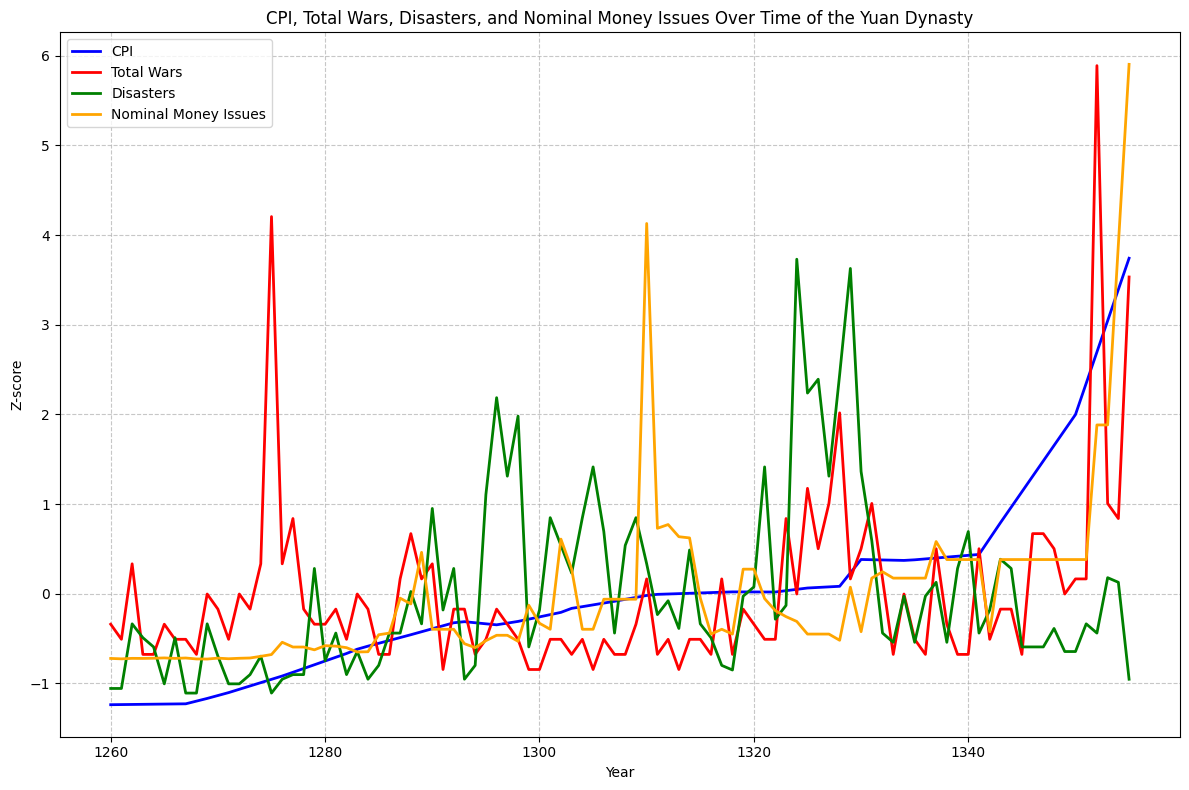

Image saved at: /Users/rishisiddharth/Desktop/LSE_2024_2045/classes/Ds202W/ds202w-2025-2024-w10-summative-Rsiddharth54/yuan_dynasty_variables.png


In [ ]:
# We are using the standard scaler to normalize the data this time.
scaler = StandardScaler()

# New df with scaled data
scaled_data = scaler.fit_transform(yuan[['cpi', 'totalwar', 'disaster', 'nominal']])


yuan_scaled = pd.DataFrame(scaled_data, columns=['CPI_normalized', 'wars_normalized', 'disasters_normalized', 'nominal_normalized'])

plt.figure(figsize=(12, 8))
plt.plot(yuan['year'], yuan_scaled['CPI_normalized'], label='CPI', color='blue', linewidth=2)
plt.plot(yuan['year'], yuan_scaled['wars_normalized'], label='Total Wars', color='red', linewidth=2)
plt.plot(yuan['year'], yuan_scaled['disasters_normalized'], label='Disasters', color='green', linewidth=2)
plt.plot(yuan['year'], yuan_scaled['nominal_normalized'], label='Nominal Money Issues', color='orange', linewidth=2)
plt.title('CPI, Total Wars, Disasters, and Nominal Money Issues Over Time of the Yuan Dynasty')
plt.xlabel('Year')
plt.ylabel('Z-score')
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.tight_layout()


save_path = "yuan_dynasty_variables.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

# Print the absolute path to the saved image
abs_path = os.path.abspath(save_path)
print(f"Image saved at: {abs_path}")

OLS Model for Training Data:
                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     19.43
Date:                Thu, 27 Mar 2025   Prob (F-statistic):           4.94e-09
Time:                        16:26:34   Log-Likelihood:                -238.68
No. Observations:                  67   AIC:                             485.4
Df Residuals:                      63   BIC:                             494.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.5711  

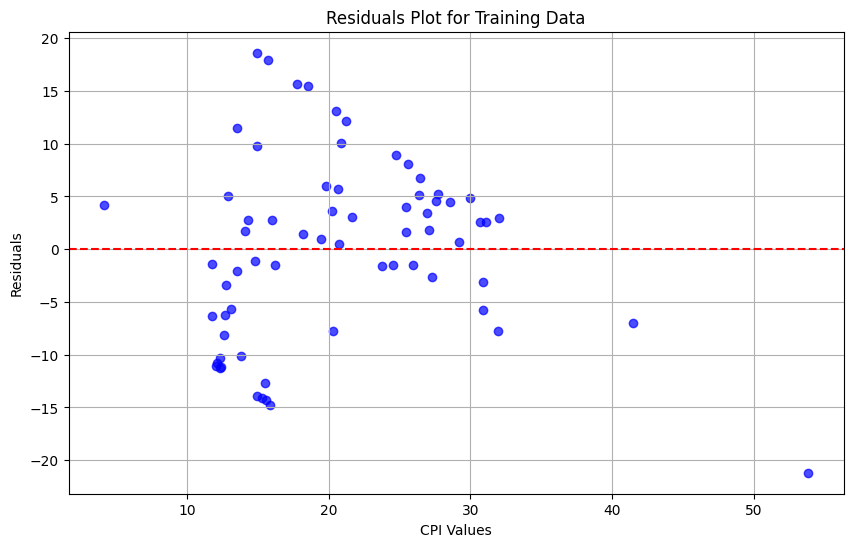

In [ ]:
yuan = pd.read_stata("Data/yuan_inflation_data.dta")
yuan_train = yuan[yuan['year'] < 1327].copy()
yuan_test = yuan[yuan['year'] >= 1327].copy()


features = ['totalwar', 'disaster', 'nominal']
target = 'cpi'


X_train = yuan_train[features]
y_train = yuan_train[target]

#Add constant term for intercept
X_train_const = sm.add_constant(X_train)

#Train the OLS model on training data (pre-1327)
ols_model = sm.OLS(y_train, X_train_const)
results = ols_model.fit()


print("OLS Model for Training Data:")
print(results.summary())


fitted_values = results.fittedvalues
residuals = y_train - fitted_values
train_r2 = results.rsquared
train_rmse = np.sqrt(mean_squared_error(y_train, fitted_values))

print("\nPerformance on Training Data:")
print("R-squared:", np.round(train_r2, 2))
print("Root Mean Squared Error (RMSE):", np.round(train_rmse, 2))

plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.7, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('CPI Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot for Training Data')
plt.grid(True)
plt.show()

In [ ]:
X_test = yuan_test[features]
y_test = yuan_test[target]
X_test_const = sm.add_constant(X_test)

#We use the pre-1327 trained model to predict post-1327 data
y_test_pred = results.predict(X_test_const)  
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Performance of Training Model on Test Data:")
print("Test R-squared:", np.round(test_r2, 2))
print("Test Root Mean Squared Error (RMSE):", np.round(test_rmse, 2))

Performance of Training Model on Test Data:
Test R-squared: -1.48
Test Root Mean Squared Error (RMSE): 42.35


OLS Model for Training Data:
                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     209.8
Date:                Thu, 27 Mar 2025   Prob (F-statistic):           2.77e-35
Time:                        16:26:39   Log-Likelihood:                -170.97
No. Observations:                  67   AIC:                             351.9
Df Residuals:                      62   BIC:                             363.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.

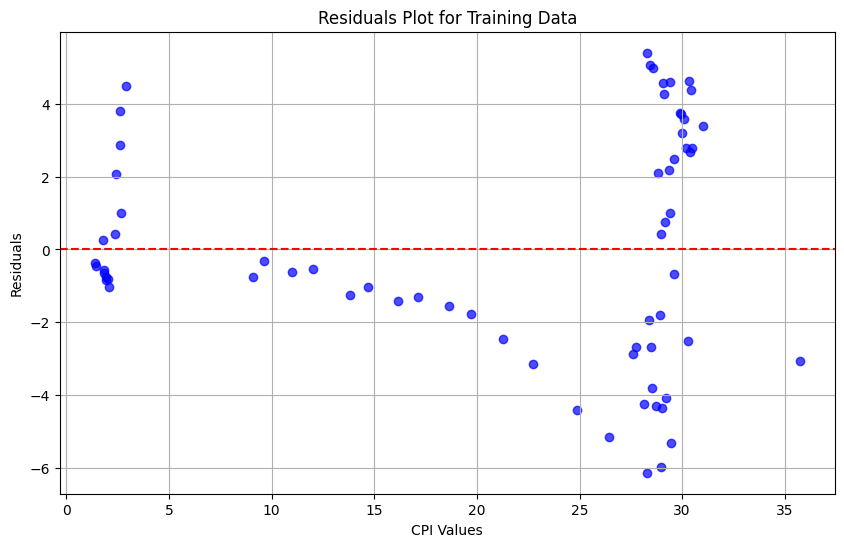

In [ ]:
#feature engineering - combine all of warfare into 1 variable: total_conflict

yuan['total_conflict'] = yuan['external'] + yuan['unification'] + yuan['totalwar']

#combine all of unrest into 1 variable: total_unrest
yuan['total_unrest'] = yuan['total_conflict'] + yuan['rebellion']
yuan_train = yuan[yuan['year'] < 1327].copy()
yuan_test = yuan[yuan['year'] >= 1327].copy()

features = ['total_unrest', 'disaster', 'nominal', 'pop']
target = 'cpi'
X_train = yuan_train[features]
y_train = yuan_train[target]
#Add a constant as the intercept
X_train_const = sm.add_constant(X_train)


ols_model = sm.OLS(y_train, X_train_const)
results = ols_model.fit()
print("OLS Model for Training Data:")
print(results.summary())


fitted_values = results.fittedvalues
residuals = y_train - fitted_values
r2 = results.rsquared
rmse = np.sqrt(mean_squared_error(y_train, fitted_values))
print("\nPerformance on Training Data:")
print("R-squared:", np.round(r2, 2))
print("Root Mean Squared Error (RMSE):", np.round(rmse, 2))

plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.7, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('CPI Values')
plt.ylabel('Residuals')
plt.title('Residuals Plot for Training Data')
plt.grid(True)
plt.show()


OLS Model for Test Data:
                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     18.61
Date:                Thu, 27 Mar 2025   Prob (F-statistic):           4.44e-07
Time:                        16:26:42   Log-Likelihood:                -116.15
No. Observations:                  29   AIC:                             242.3
Df Residuals:                      24   BIC:                             249.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -104.660

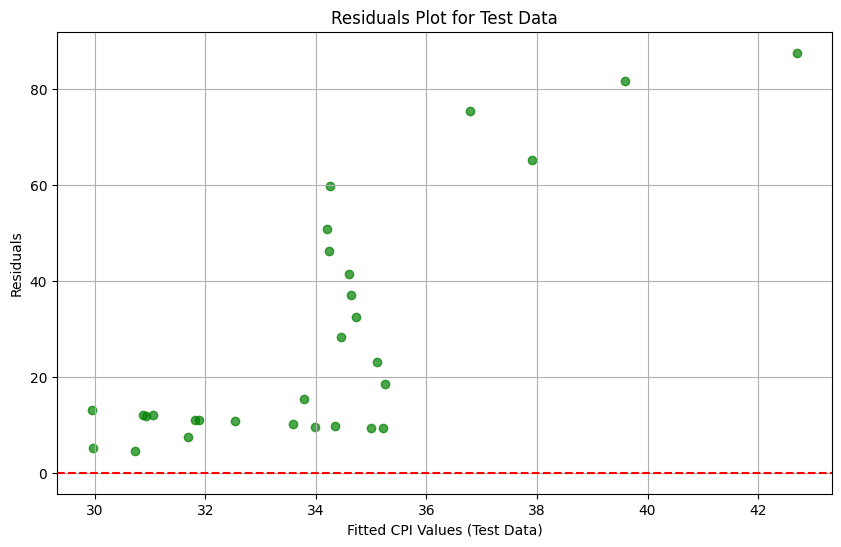

In [ ]:
X_test = yuan_test[features]
y_test = yuan_test[target]

#
X_test_const = sm.add_constant(X_test)


ols_test_model = sm.OLS(y_test, X_test_const)
results_test = ols_test_model.fit()


print("\nOLS Model for Test Data:")
print(results_test.summary())


# Use the pre-1327 trained model (results from training) to predict post-1327 data
y_test_pred = results.predict(X_test_const)


test_residuals = y_test - y_test_pred

#Calculate performance metrics on the test data
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\nPerformance on Test Data:")
print("Test R-squared:", np.round(test_r2, 2))
print("Test Root Mean Squared Error (RMSE):", np.round(test_rmse, 2))


plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, test_residuals, alpha=0.7, color='green')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted CPI Values (Test Data)')
plt.ylabel('Residuals')
plt.title('Residuals Plot for Test Data')
plt.grid(True)
plt.show()


Performance on Training Data:
R-squared: 1.00
RMSE: 0.33

Performance on Test Data:
R-squared: -1.06
RMSE: 38.64


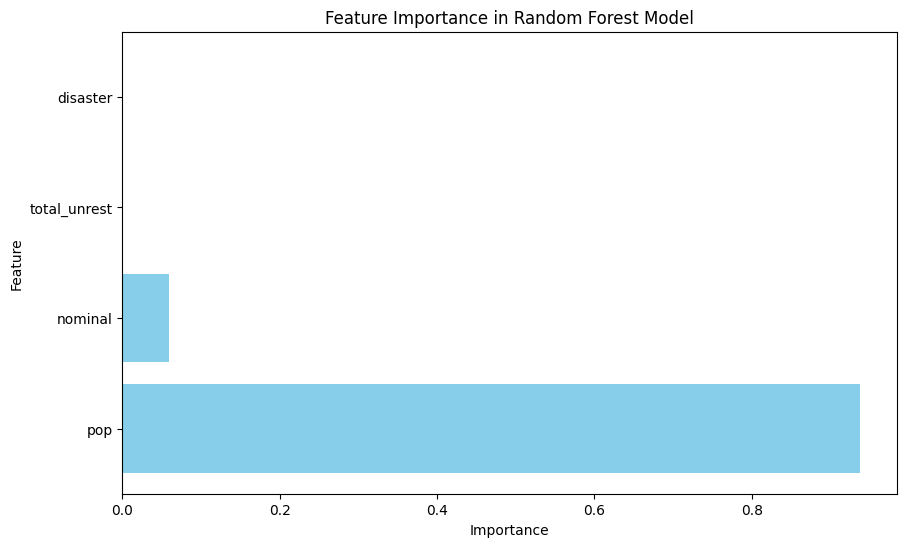

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Load the data
yuan = pd.read_stata("Data/yuan_inflation_data.dta")

# Feature engineering
yuan['total_conflict'] = yuan['external'] + yuan['unification'] + yuan['totalwar']
yuan['total_unrest'] = yuan['total_conflict'] + yuan['rebellion']  # Fixed syntax

features = ['total_unrest', 'disaster', 'nominal', 'pop']
target = 'cpi'

# Train-test split
train = yuan[yuan['year'] < 1327].copy()
test = yuan[yuan['year'] >= 1327].copy()

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

# Train model (no scaling needed)
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=2,
    random_state=42
)
rf_model.fit(X_train, y_train)  # Use raw features

# Predictions
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Performance metrics (original scale only)
train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\nPerformance on Training Data:")
print(f"R-squared: {train_r2:.2f}")
print(f"RMSE: {train_rmse:.2f}")

print("\nPerformance on Test Data:")
print(f"R-squared: {test_r2:.2f}")
print(f"RMSE: {test_rmse:.2f}")

# Feature importance
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.show()

Best alpha value: 0.022229964825261957

Performance on Training Data:
R-squared: 0.93
RMSE: 3.10

Performance on Test Data:
R-squared: -0.92
RMSE: 37.30


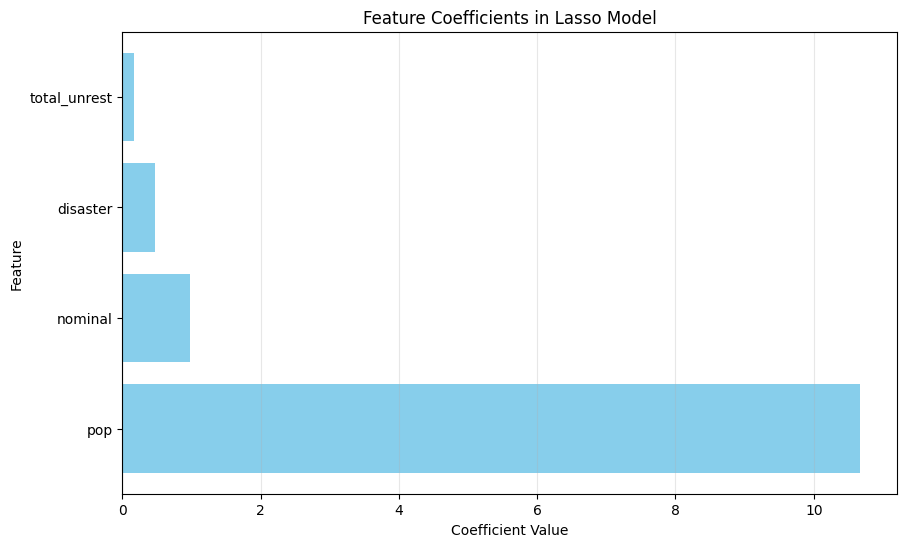

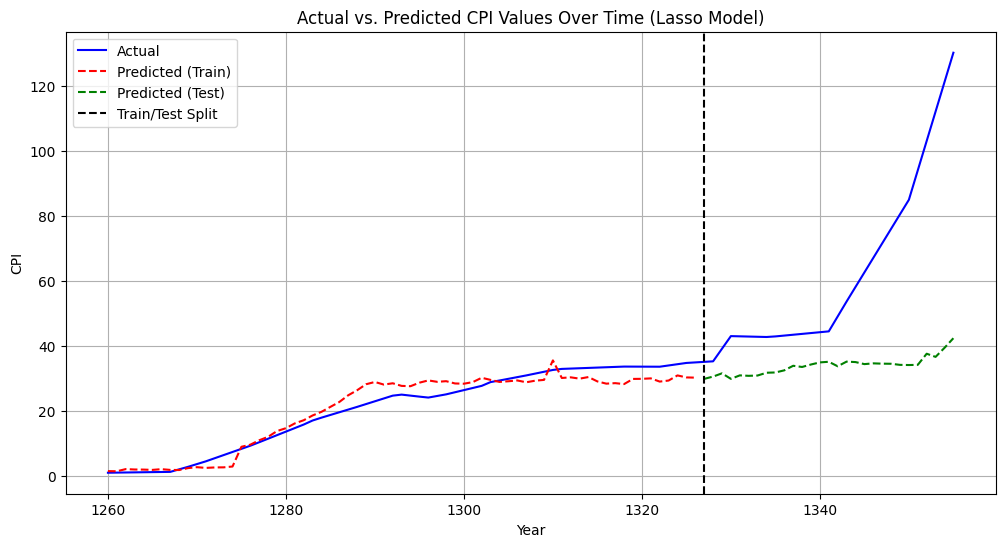


Non-zero coefficients (features selected by Lasso):
pop: 10.676051
nominal: 0.984482
disaster: 0.477754
total_unrest: 0.168518


In [ ]:
yuan = pd.read_stata("Data/yuan_inflation_data.dta")


yuan['total_conflict'] = yuan['external'] + yuan['unification'] + yuan['totalwar']
yuan['total_unrest'] = yuan['total_conflict'] + yuan['rebellion']


features = ['total_unrest', 'disaster', 'nominal', 'pop']
target = 'cpi'


train = yuan[yuan['year'] < 1327].copy()
test = yuan[yuan['year'] >= 1327].copy()

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


param_grid = {'alpha': np.logspace(-4, 1, 50)}  
tscv = TimeSeriesSplit(n_splits=5)

lasso_cv = GridSearchCV(
    Lasso(max_iter=10000, random_state=42), 
    param_grid, 
    cv=tscv,
    scoring='neg_mean_squared_error'
)

lasso_cv.fit(X_train_scaled, y_train)
best_alpha = lasso_cv.best_params_['alpha']
print(f"Best alpha value: {best_alpha}")


lasso_model = Lasso(alpha=best_alpha, max_iter=10000, random_state=42)
lasso_model.fit(X_train_scaled, y_train)


y_train_pred = lasso_model.predict(X_train_scaled)
y_test_pred = lasso_model.predict(X_test_scaled)


train_r2 = r2_score(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\nPerformance on Training Data:")
print(f"R-squared: {train_r2:.2f}")
print(f"RMSE: {train_rmse:.2f}")

print("\nPerformance on Test Data:")
print(f"R-squared: {test_r2:.2f}")
print(f"RMSE: {test_rmse:.2f}")


coef = pd.Series(lasso_model.coef_, index=features)
importance = pd.DataFrame({'Feature': features, 'Coefficient': coef.values})
importance = importance.sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Coefficients in Lasso Model')
plt.axvline(x=0, color='gray', linestyle='-', alpha=0.7)
plt.grid(True, axis='x', alpha=0.3)
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(yuan['year'], yuan[target], 'b-', label='Actual')
plt.plot(train['year'], y_train_pred, 'r--', label='Predicted (Train)')
plt.plot(test['year'], y_test_pred, 'g--', label='Predicted (Test)')
plt.axvline(x=1327, color='k', linestyle='--', label='Train/Test Split')
plt.xlabel('Year')
plt.ylabel('CPI')
plt.title('Actual vs. Predicted CPI Values Over Time (Lasso Model)')
plt.legend()
plt.grid(True)
plt.show()


non_zero = coef[coef != 0].sort_values(key=abs, ascending=False)
print("\nNon-zero coefficients (features selected by Lasso):")
for feature, coefficient in non_zero.items():
    print(f"{feature}: {coefficient:.6f}")

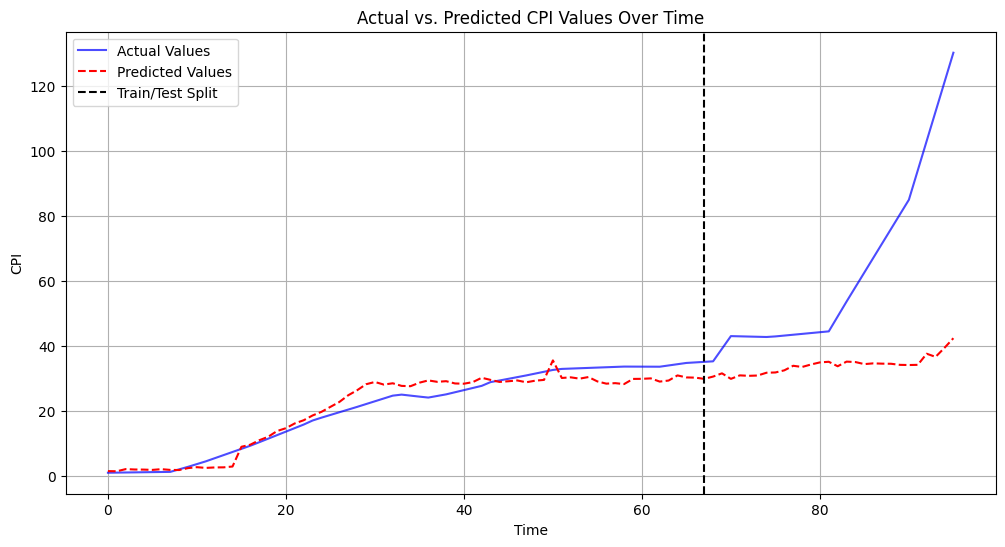

In [ ]:
#creates a full index that spans the full dataset length
full_index = np.arange(len(y_train) + len(y_test))


actual_values = np.concatenate([y_train.values, y_test.values])

#concatenates the  predicted values (train + test)
predicted_values = np.concatenate([y_train_pred, y_test_pred])


plt.figure(figsize=(12, 6))
plt.plot(full_index, actual_values, label='Actual Values', color='blue', alpha=0.7)
plt.plot(full_index, predicted_values, label='Predicted Values', color='red', linestyle='--')


plt.axvline(x=len(y_train), color='black', linestyle='dashed', label='Train/Test Split')

plt.xlabel('Time')
plt.ylabel('CPI')
plt.title('Actual vs. Predicted CPI Values Over Time')
plt.legend()
plt.grid(True)
plt.show()

Model with Regime Interactions:
                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     135.7
Date:                Thu, 27 Mar 2025   Prob (F-statistic):           7.38e-48
Time:                        16:26:57   Log-Likelihood:                -312.98
No. Observations:                  96   AIC:                             648.0
Df Residuals:                      85   BIC:                             676.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
co

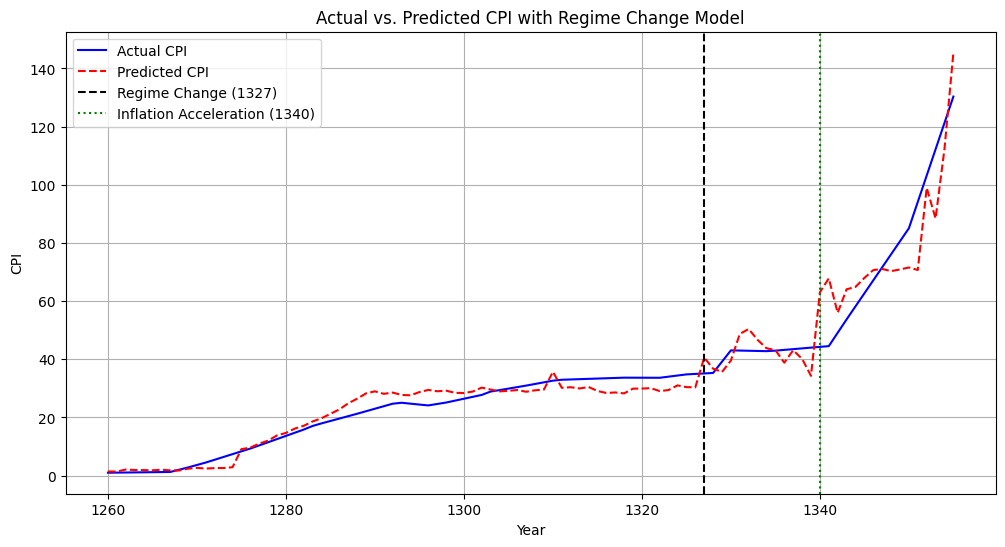


Effect of predictors in Silver Regime (pre-1327):
total_unrest: 0.023223
disaster: 0.025180
nominal: 0.000000
pop: 0.000000

Effect of predictors in Fiat Regime (post-1327):
total_unrest: 0.144287
disaster: -0.210741
nominal: 0.000002
pop: -0.000002


In [ ]:
yuan['total_conflict'] = yuan['external'] + yuan['unification'] + yuan['totalwar']
yuan['total_unrest'] = yuan['total_conflict'] + yuan['rebellion']

yuan['fiat_regime'] = (yuan['year'] >= 1327).astype(int)  # 1 for fiat period, 0 for silver period
yuan['post_1340'] = (yuan['year'] >= 1340).astype(int)    # 1 for the period with rapidly accelerating inflation

#Create interaction terms
features = ['total_unrest', 'disaster', 'nominal', 'pop']
for feature in features:
    yuan[f'{feature}_x_fiat'] = yuan[feature] * yuan['fiat_regime']

model_features = features + [f'{feature}_x_fiat' for feature in features] + ['fiat_regime', 'post_1340']


X = yuan[model_features]
y = yuan['cpi']


X_const = sm.add_constant(X)


full_model = sm.OLS(y, X_const)
results = full_model.fit()


print("Model with Regime Interactions:")
print(results.summary())


predictions = results.predict(X_const)
r2 = r2_score(y, predictions)
rmse = np.sqrt(mean_squared_error(y, predictions))

print(f"\nOverall Model Performance:")
print(f"R-squared: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")

#Evaluate performance separately for each regime
silver_mask = yuan['fiat_regime'] == 0
fiat_mask = yuan['fiat_regime'] == 1

silver_r2 = r2_score(y[silver_mask], predictions[silver_mask])
silver_rmse = np.sqrt(mean_squared_error(y[silver_mask], predictions[silver_mask]))

fiat_r2 = r2_score(y[fiat_mask], predictions[fiat_mask])
fiat_rmse = np.sqrt(mean_squared_error(y[fiat_mask], predictions[fiat_mask]))

print(f"\nSilver Regime (pre-1327) Performance:")
print(f"R-squared: {silver_r2:.2f}")
print(f"RMSE: {silver_rmse:.2f}")

print(f"\nFiat Regime (post-1327) Performance:")
print(f"R-squared: {fiat_r2:.2f}")
print(f"RMSE: {fiat_rmse:.2f}")

# Visualize actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(yuan['year'], y, 'b-', label='Actual CPI')
plt.plot(yuan['year'], predictions, 'r--', label='Predicted CPI')
plt.axvline(x=1327, color='k', linestyle='--', label='Regime Change (1327)')
plt.axvline(x=1340, color='g', linestyle=':', label='Inflation Acceleration (1340)')
plt.xlabel('Year')
plt.ylabel('CPI')
plt.title('Actual vs. Predicted CPI with Regime Change Model')
plt.legend()
plt.grid(True)
plt.show()

# Analyse coefficient changes between regimes
print("\nEffect of predictors in Silver Regime (pre-1327):")
for feature in features:
    print(f"{feature}: {results.params[feature]:.6f}")

print("\nEffect of predictors in Fiat Regime (post-1327):")
for feature in features:
    print(f"{feature}: {results.params[feature] + results.params[f'{feature}_x_fiat']:.6f}")

In [ ]:
yuan['fiat_regime'] = (yuan['year'] >= 1327).astype(int)  # 1 for post-1327, 0 for pre-1327
yuan['post_1340'] = (yuan['year'] >= 1340).astype(int)    # 1 for acceleration period

In [ ]:
for feature in features:
    yuan[f'{feature}_x_fiat'] = yuan[feature] * yuan['fiat_regime']

In [ ]:
model_features = features + [f'{feature}_x_fiat' for feature in features] + ['fiat_regime', 'post_1340']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         68 non-null     object 
 1   Rate         68 non-null     float64
 2   rate_change  68 non-null     int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ KB
         Date  Rate  rate_change
0  1997-05-06  6.25            1
1  1997-06-06  6.50            1
2  1997-07-10  6.75            1
3  1997-08-07  7.00            1
4  1997-11-06  7.25            1
5  1998-06-04  7.50            1
6  1998-10-08  7.25           -1
7  1998-11-05  6.75           -1
8  1998-12-10  6.25           -1
9  1999-01-07  6.00           -1
0        NaT
1    31 days
2    34 days
3    28 days
4    91 days
5   210 days
6   126 days
7    28 days
8    35 days
9    28 days
Name: time_diff, dtype: timedelta64[ns]


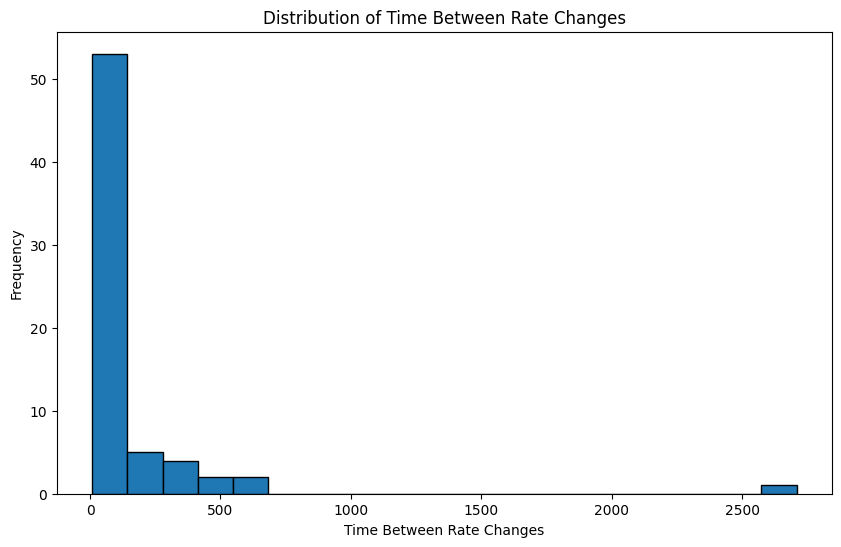

In [ ]:
# Load data set, explore it a little
df = pd.read_csv('Boe_interest_rates.csv')
df.info()
df.describe()
print(df.head(10))

#three columns, date, rate, and rate change

#when the rates increase, the rate change is positive, thus is 1, if it decreases, it is 0

#convert the date column to a datetime object
# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.head(10)




#lets explore the distribution of time between rate changes

df['time_diff'] = df['Date'].diff()
print(df['time_diff'].head(10))



#diff - Calculates the difference of a DataFrame element compared with another element in the DataFrame (default is element in previous row).


#convert time_diff to a number
df['time_diff_days'] = df['time_diff'].dt.days





#graph it - use histogram it
plt.figure(figsize=(10, 6))
plt.hist(df['time_diff_days'], bins=20, edgecolor='black')
plt.xlabel('Time Between Rate Changes')
plt.ylabel('Frequency')
plt.title('Distribution of Time Between Rate Changes')
plt.show()



# The vast majority of events occur with a short time difference (around 30 days), which suggests that the Bank of England typically has monthly rate-setting meetings.

In [ ]:
#download the economic indicators dataset
economic_indicators = pd.read_csv('economic_indicators_interest_rate_setting.csv')
#assign each row of the df values of economic indicators from the last quarter i.e the average of each indicator for the last three months up to the date of the rate setting event. 
print(economic_indicators.head(10))

economic_indicators = economic_indicators.sort_values('Date')
print(economic_indicators.columns)

         Date       CCI  \
0  1997-01-01  102.2504   
1  1997-02-01  102.5327   
2  1997-03-01  102.6905   
3  1997-04-01  102.7900   
4  1997-05-01  102.9294   
5  1997-06-01  102.9378   
6  1997-07-01  102.8648   
7  1997-08-01  102.8713   
8  1997-09-01  102.9758   
9  1997-10-01  103.0225   

   Unemployment rate (aged 16 and over, seasonally adjusted): %  \
0                                                7.5              
1                                                7.3              
2                                                7.2              
3                                                7.2              
4                                                7.2              
5                                                7.3              
6                                                7.1              
7                                                6.8              
8                                                6.7              
9                               

In [ ]:
df_indicators = df
econ_df = economic_indicators
#new column ames
econ_df = econ_df.rename(columns={
    'Unemployment rate (aged 16 and over, seasonally adjusted): %': 'Unemployment_rate',
    '10-year-gilt-yield': '10_year_gilt_yield',
    'CPIH MONTHLY RATE 00: ALL ITEMS 2015=100': 'CPIH',
    'Gross Value Added - Monthly (Index 1dp) :CVM SA': 'GDP',
    'Monthly average Spot exchange rate, Sterling into US$              [a]             XUMAGBD': 'Exchange_rate_USD',
    'Monthly average Spot exchange rates, Sterling into Euro              [a]             XUMASER': 'Exchange_rate_EUR'
})

#convert dates to datetime
df['Date'] = pd.to_datetime(df['Date'])
econ_df['Date'] = pd.to_datetime(econ_df['Date'])

#  monthly period columns
df['event_month'] = df['Date'].dt.to_period('M')
econ_df['year_month'] = econ_df['Date'].dt.to_period('M')

#Calculate prior 3 months for each event
df['prior_months'] = df['event_month'].apply(lambda m: [m - i for i in range(1, 4)])

#Explode and merge
df_combined = df.explode('prior_months')
merged = df_combined.merge(
    econ_df,
    left_on='prior_months',
    right_on='year_month',
    how='left'
)
#sql techniques
print(df_combined.head(10)) 
indicators = ['GDP', 'Unemployment_rate', '10_year_gilt_yield', 'CPIH', 'CCI', 'Exchange_rate_USD']
averages = merged.groupby(merged.index)[indicators].mean()
averages.columns = [f'{col}_3m_avg' for col in averages.columns]


final_df = df.join(averages)
final_df.drop(columns=['event_month', 'prior_months'], inplace=True)

print("the final dataframe is:")
print(final_df.head(10))

print(final_df.columns)

        Date  Rate  rate_change time_diff  time_diff_days event_month  \
0 1997-05-06  6.25            1       NaT             NaN     1997-05   
0 1997-05-06  6.25            1       NaT             NaN     1997-05   
0 1997-05-06  6.25            1       NaT             NaN     1997-05   
1 1997-06-06  6.50            1   31 days            31.0     1997-06   
1 1997-06-06  6.50            1   31 days            31.0     1997-06   
1 1997-06-06  6.50            1   31 days            31.0     1997-06   
2 1997-07-10  6.75            1   34 days            34.0     1997-07   
2 1997-07-10  6.75            1   34 days            34.0     1997-07   
2 1997-07-10  6.75            1   34 days            34.0     1997-07   
3 1997-08-07  7.00            1   28 days            28.0     1997-08   

  prior_months  
0      1997-04  
0      1997-03  
0      1997-02  
1      1997-05  
1      1997-04  
1      1997-03  
2      1997-06  
2      1997-05  
2      1997-04  
3      1997-07  
the final

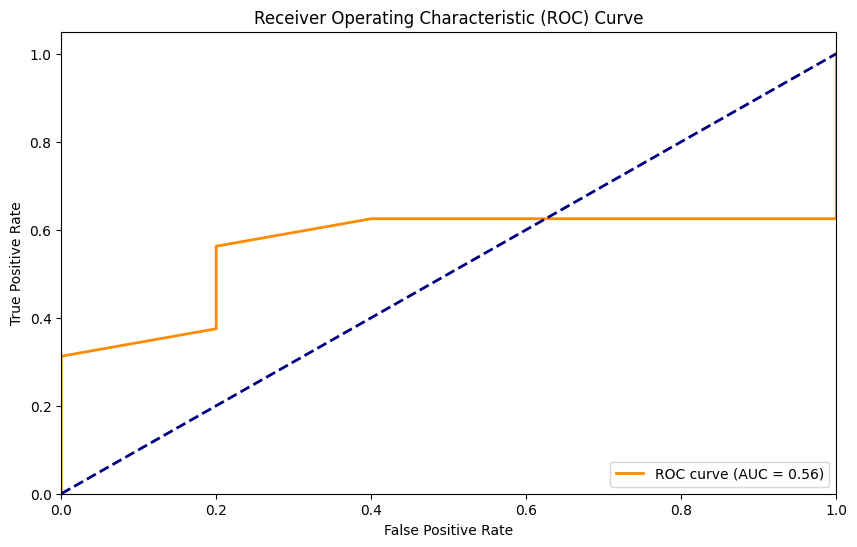

Model Evaluation Metrics:

Classification Report:
              precision    recall  f1-score   support

          -1       0.24      1.00      0.38         5
           1       0.00      0.00      0.00        16

    accuracy                           0.24        21
   macro avg       0.12      0.50      0.19        21
weighted avg       0.06      0.24      0.09        21



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

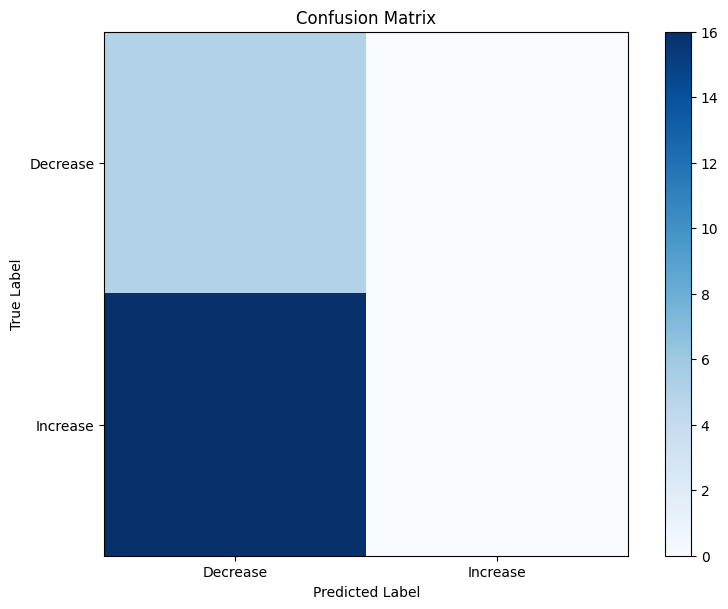

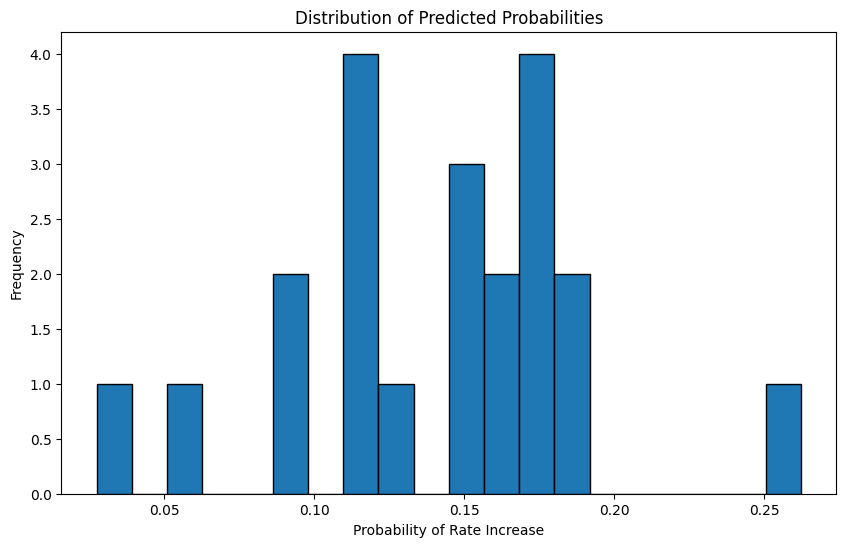


Sample Probability Predictions:
Actual: 1, Predicted Probability of Rate Increase: 0.0542
Actual: 1, Predicted Probability of Rate Increase: 0.0275
Actual: -1, Predicted Probability of Rate Increase: 0.1260
Actual: -1, Predicted Probability of Rate Increase: 0.1108
Actual: 1, Predicted Probability of Rate Increase: 0.0909
Actual: 1, Predicted Probability of Rate Increase: 0.1551
Actual: 1, Predicted Probability of Rate Increase: 0.2623
Actual: 1, Predicted Probability of Rate Increase: 0.1680
Actual: 1, Predicted Probability of Rate Increase: 0.1773
Actual: 1, Predicted Probability of Rate Increase: 0.0909

Feature Importance:
GDP_3m_avg: 0.8699
10_year_gilt_yield_3m_avg: 0.8190
Unemployment_rate_3m_avg: 0.3419
Exchange_rate_USD_3m_avg: 0.2756
CCI_3m_avg: 0.1418
CPIH_3m_avg: 0.1369


In [ ]:
from sklearn.linear_model import LogisticRegression #imports werent working
from sklearn.metrics import (
    roc_curve, 
    roc_auc_score, 
    precision_recall_curve, 
    average_precision_score,
    confusion_matrix, 
    classification_report
)

#features from the previous model
features = [
    'GDP_3m_avg', 
    'Unemployment_rate_3m_avg', 
    '10_year_gilt_yield_3m_avg', 
    'CPIH_3m_avg', 
    'CCI_3m_avg', 
    'Exchange_rate_USD_3m_avg'
]

#predicting rate change
X = final_df[features]
y = final_df['rate_change']


df_sorted = final_df.sort_values('Date')
split_index = int(len(df_sorted) * 0.7)


X_train = df_sorted.iloc[:split_index][features]
X_test = df_sorted.iloc[split_index:][features]
y_train = df_sorted.iloc[:split_index]['rate_change']
y_test = df_sorted.iloc[split_index:]['rate_change']

#scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

#predict probabilities
y_pred_proba = lr_model.predict_proba(X_test_scaled)
y_pred = lr_model.predict(X_test_scaled)

#roc curve
plt.figure(figsize=(10, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

#model evaluation metrics
print("Model Evaluation Metrics:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Decrease', 'Increase'])
plt.yticks(tick_marks, ['Decrease', 'Increase'])



plt.tight_layout()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')
plt.show()

#Feature Importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': np.abs(lr_model.coef_[0])
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance in Predicting Rate Change')
plt.xlabel('Features')
plt.ylabel('Absolute Coefficient Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

#probability distribution
plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba[:, 1], bins=20, edgecolor='black')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Probability of Rate Increase')
plt.ylabel('Frequency')
plt.savefig('probability_distribution.png')
plt.show()

# Print out  10 probability predictions
print("\nSample Probability Predictions:")
for i, (actual, prob) in enumerate(zip(y_test, y_pred_proba[:, 1]), 1):
    if i <= 10:  # Print first 10 predictions
        print(f"Actual: {actual}, Predicted Probability of Rate Increase: {prob:.4f}")


prob_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted_Probability': y_pred_proba[:, 1]
})
prob_df.to_csv('rate_change_probabilities.csv', index=False)

# Detailed Feature Importance Print
print("\nFeature Importance:")
for _, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

In [ ]:
#imports werent working
df_improved = final_df.copy()


for col in df_improved.select_dtypes(include=['float', 'int']).columns:
    df_improved[col] = df_improved[col].replace([np.inf, -np.inf], np.nan)
    df_improved[col] = df_improved[col].fillna(df_improved[col].median())

#  Engineer new features (focusing on the most important ones)
# Log transformations
for col in ['GDP_3m_avg', 'Exchange_rate_USD_3m_avg', '10_year_gilt_yield_3m_avg']:
    df_improved[f'log_{col}'] = np.log(df_improved[col].clip(lower=0.001))

# Percentage change
for col in ['GDP_3m_avg', 'CPIH_3m_avg']:
    df_improved[f'{col}_change'] = df_improved[col].pct_change().fillna(0).clip(-1, 1)

# Prepare data - use BOTH binary and original classes
# Original features
features = ['GDP_3m_avg', 'Exchange_rate_USD_3m_avg', '10_year_gilt_yield_3m_avg', 
            'Unemployment_rate_3m_avg', 'CPIH_3m_avg', 'CCI_3m_avg',
            'log_GDP_3m_avg', 'log_Exchange_rate_USD_3m_avg', 'log_10_year_gilt_yield_3m_avg',
            'GDP_3m_avg_change', 'CPIH_3m_avg_change']

# Use a 50/50 split to have more balanced classes in training
X = df_improved[features]
y = df_improved['rate_change']  # Use original multiclass target

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Split 50/50 instead of 70/30
split_point = int(0.5 * len(X_scaled_df))
X_train, X_test = X_scaled_df[:split_point], X_scaled_df[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# Train a simple model with class balancing
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

model.fit(X_train, y_train)

#  Evaluate
y_pred = model.predict(X_test)

print("Improved Model Results:")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#Show feature importance
importances = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head(5))

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, roc_auc_score, auc,
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt

# Create binary target
yuan['cpi_change'] = yuan['cpi'].diff()
yuan['high_inflation'] = (yuan['cpi_change'] > yuan['cpi_change'].median()).astype(int)
yuan = yuan.dropna()
#imports werent working
df_improved = final_df.copy()


for col in df_improved.select_dtypes(include=['float', 'int']).columns:
    df_improved[col] = df_improved[col].replace([np.inf, -np.inf], np.nan)
    df_improved[col] = df_improved[col].fillna(df_improved[col].median())

#  Engineer new features (focusing on the most important ones)
# Log transformations
for col in ['GDP_3m_avg', 'Exchange_rate_USD_3m_avg', '10_year_gilt_yield_3m_avg']:
    df_improved[f'log_{col}'] = np.log(df_improved[col].clip(lower=0.001))

# Percentage change
for col in ['GDP_3m_avg', 'CPIH_3m_avg']:
    df_improved[f'{col}_change'] = df_improved[col].pct_change().fillna(0).clip(-1, 1)

# Prepare data - use BOTH binary and original classes
# Original features
features = ['GDP_3m_avg', 'Exchange_rate_USD_3m_avg', '10_year_gilt_yield_3m_avg', 
            'Unemployment_rate_3m_avg', 'CPIH_3m_avg', 'CCI_3m_avg',
            'log_GDP_3m_avg', 'log_Exchange_rate_USD_3m_avg', 'log_10_year_gilt_yield_3m_avg',
            'GDP_3m_avg_change', 'CPIH_3m_avg_change']

# Use a 50/50 split to have more balanced classes in training
X = df_improved[features]
y = df_improved['rate_change']  # Use original multiclass target

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Split 50/50 instead of 70/30
split_point = int(0.5 * len(X_scaled_df))
X_train, X_test = X_scaled_df[:split_point], X_scaled_df[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# Train a simple model with class balancing
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

model.fit(X_train, y_train)

#  Evaluate
y_pred = model.predict(X_test)

print("Improved Model Results:")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#Show feature importance
importances = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head(5))

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, roc_auc_score, auc,
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
# Create binary target
yuan['cpi_change'] = yuan['cpi'].diff()
yuan['high_inflation'] = (yuan['cpi_change'] > yuan['cpi_change'].median()).astype(int)
yuan = yuan.dropna()
#imports werent working
df_improved = final_df.copy()


for col in df_improved.select_dtypes(include=['float', 'int']).columns:
    df_improved[col] = df_improved[col].replace([np.inf, -np.inf], np.nan)
    df_improved[col] = df_improved[col].fillna(df_improved[col].median())

#  Engineer new features (focusing on the most important ones)
# Log transformations
for col in ['GDP_3m_avg', 'Exchange_rate_USD_3m_avg', '10_year_gilt_yield_3m_avg']:
    df_improved[f'log_{col}'] = np.log(df_improved[col].clip(lower=0.001))

# Percentage change
for col in ['GDP_3m_avg', 'CPIH_3m_avg']:
    df_improved[f'{col}_change'] = df_improved[col].pct_change().fillna(0).clip(-1, 1)

# Prepare data - use BOTH binary and original classes
# Original features
features = ['GDP_3m_avg', 'Exchange_rate_USD_3m_avg', '10_year_gilt_yield_3m_avg', 
            'Unemployment_rate_3m_avg', 'CPIH_3m_avg', 'CCI_3m_avg',
            'log_GDP_3m_avg', 'log_Exchange_rate_USD_3m_avg', 'log_10_year_gilt_yield_3m_avg',
            'GDP_3m_avg_change', 'CPIH_3m_avg_change']

# Use a 50/50 split to have more balanced classes in training
X = df_improved[features]
y = df_improved['rate_change']  # Use original multiclass target

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Split 50/50 instead of 70/30
split_point = int(0.5 * len(X_scaled_df))
X_train, X_test = X_scaled_df[:split_point], X_scaled_df[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# Train a simple model with class balancing
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

model.fit(X_train, y_train)

#  Evaluate
y_pred = model.predict(X_test)

print("Improved Model Results:")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#Show feature importance
importances = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head(5))

Improved Model Results:

Confusion Matrix:
[[ 1 14]
 [ 3 16]]

Classification Report:
              precision    recall  f1-score   support

          -1       0.25      0.07      0.11        15
           1       0.53      0.84      0.65        19

    accuracy                           0.50        34
   macro avg       0.39      0.45      0.38        34
weighted avg       0.41      0.50      0.41        34


Top 5 Most Important Features:
                          Feature  Importance
7    log_Exchange_rate_USD_3m_avg    0.200043
1        Exchange_rate_USD_3m_avg    0.141669
10             CPIH_3m_avg_change    0.121319
8   log_10_year_gilt_yield_3m_avg    0.099381
9               GDP_3m_avg_change    0.090088


Could not generate feature importance plot: All arrays must be of the same length


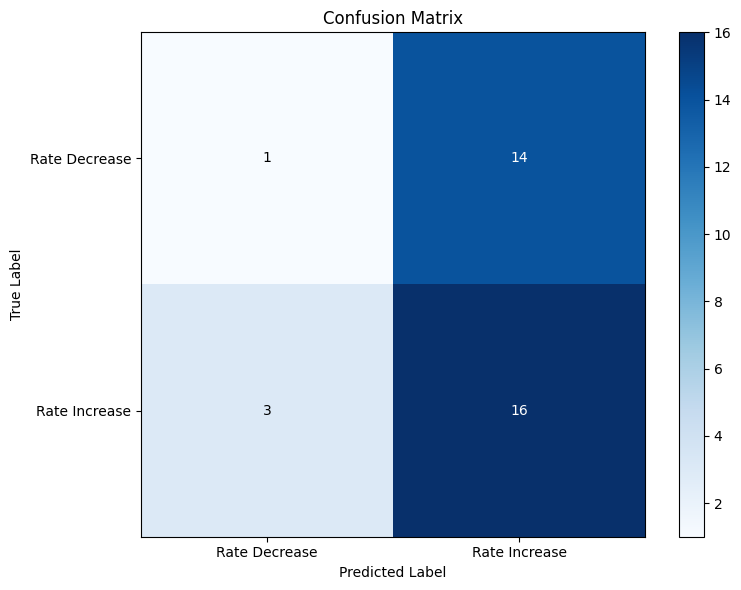

Could not generate ROC curve: X has 11 features, but LogisticRegression is expecting 6 features as input.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


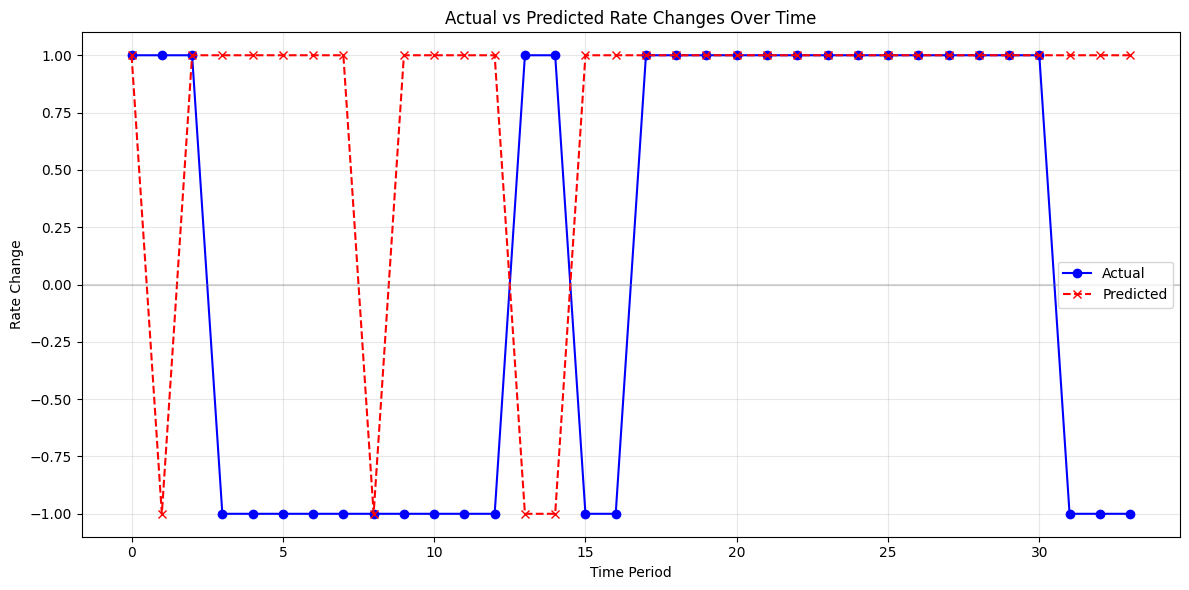

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve, 
    roc_auc_score, 
    precision_recall_curve, 
    average_precision_score,
    confusion_matrix, 
    classification_report,
    auc  # Add auc import here
)

# Make sure your model variable names are consistent
# If lr_model is your model, use that throughout the code

# Feature Importance Plot
try:
    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': np.abs(lr_model.coef_[0])
    })
    
    # Sort it for plotting
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Absolute Coefficient Magnitude')
    plt.ylabel('Feature')
    plt.title('Feature Importance - Logistic Regression')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not generate feature importance plot: {e}")

# Confusion Matrix 
try:
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = [0, 1]
    plt.xticks(tick_marks, ['Rate Decrease', 'Rate Increase'])
    plt.yticks(tick_marks, ['Rate Decrease', 'Rate Increase'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Add text annotations in the cells
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
                    
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not generate confusion matrix: {e}")

# ROC Curve
try:
    # Use lr_model consistently
    y_scores = lr_model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test == 1, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not generate ROC curve: {e}")

# Time Series Plot of Actual vs Predicted
try:
    plt.figure(figsize=(12, 6)) 
    indices = range(len(y_test))
    actual = y_test.values
    predicted = y_pred
    
    plt.plot(indices, actual, 'b-', label='Actual', marker='o')
    plt.plot(indices, predicted, 'r--', label='Predicted', marker='x')
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    plt.ylabel('Rate Change')
    plt.xlabel('Time Period')
    plt.title('Actual vs Predicted Rate Changes Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not generate time series plot: {e}")

Could not generate feature importance plot: All arrays must be of the same length


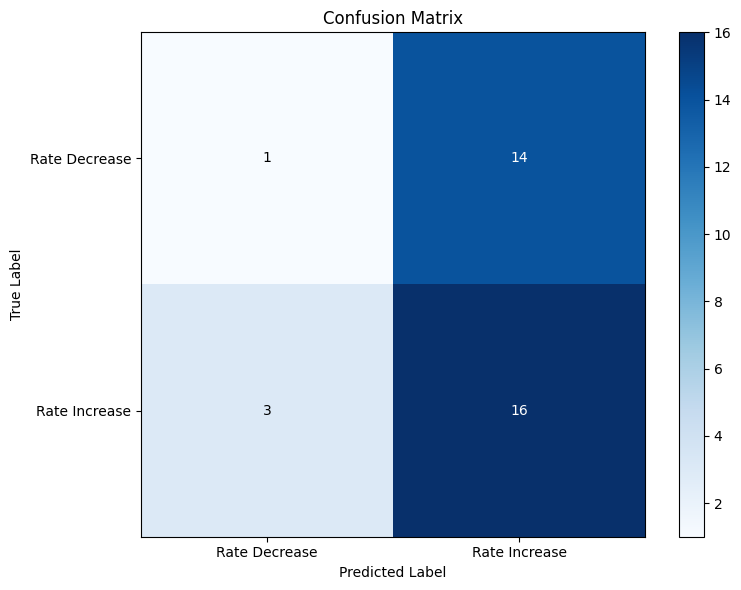

Could not generate ROC curve: X has 11 features, but LogisticRegression is expecting 6 features as input.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


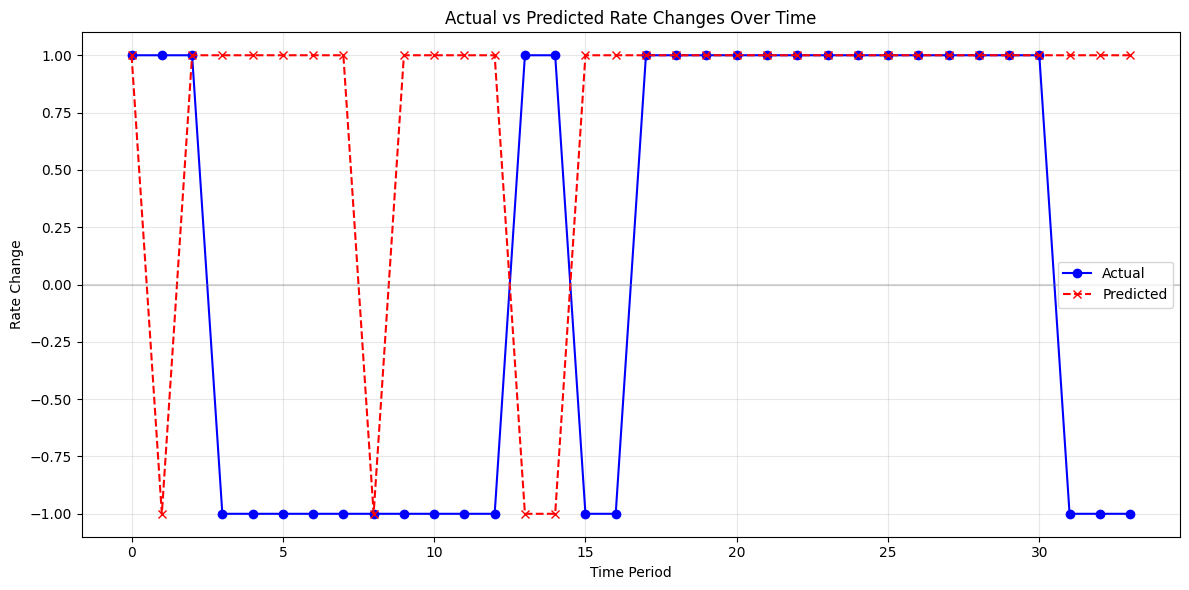

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve, 
    roc_auc_score, 
    precision_recall_curve, 
    average_precision_score,
    confusion_matrix, 
    classification_report,
    auc  # Add auc import here
)

# Make sure your model variable names are consistent
# If lr_model is your model, use that throughout the code

# Feature Importance Plot
try:
    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': np.abs(lr_model.coef_[0])
    })
    
    # Sort it for plotting
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Absolute Coefficient Magnitude')
    plt.ylabel('Feature')
    plt.title('Feature Importance - Logistic Regression')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not generate feature importance plot: {e}")

# Confusion Matrix 
try:
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = [0, 1]
    plt.xticks(tick_marks, ['Rate Decrease', 'Rate Increase'])
    plt.yticks(tick_marks, ['Rate Decrease', 'Rate Increase'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Add text annotations in the cells
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
                    
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not generate confusion matrix: {e}")

# ROC Curve
try:
    # Use lr_model consistently
    y_scores = lr_model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test == 1, y_scores)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not generate ROC curve: {e}")

# Time Series Plot of Actual vs Predicted
try:
    plt.figure(figsize=(12, 6)) 
    indices = range(len(y_test))
    actual = y_test.values
    predicted = y_pred
    
    plt.plot(indices, actual, 'b-', label='Actual', marker='o')
    plt.plot(indices, predicted, 'r--', label='Predicted', marker='x')
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    plt.ylabel('Rate Change')
    plt.xlabel('Time Period')
    plt.title('Actual vs Predicted Rate Changes Over Time')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Could not generate time series plot: {e}")

Training shapes: (65, 4) (65,)
Testing shapes: (28, 4) (28,)

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.92      0.65        12
           1       0.83      0.31      0.45        16

    accuracy                           0.57        28
   macro avg       0.67      0.61      0.55        28
weighted avg       0.69      0.57      0.54        28



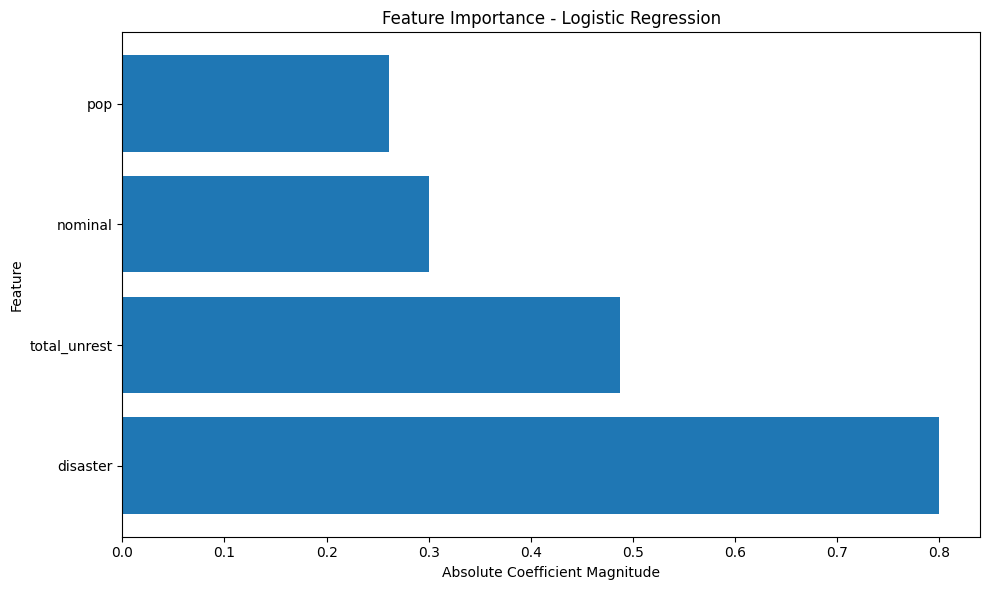

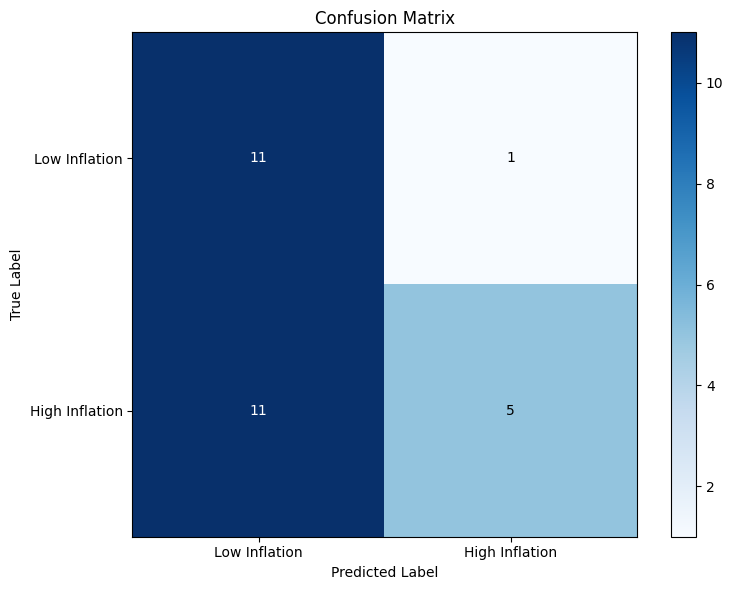

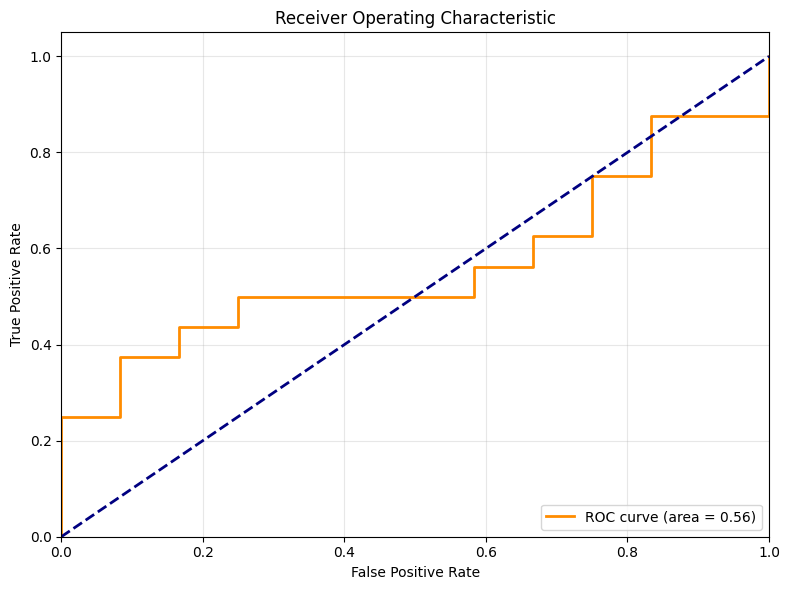

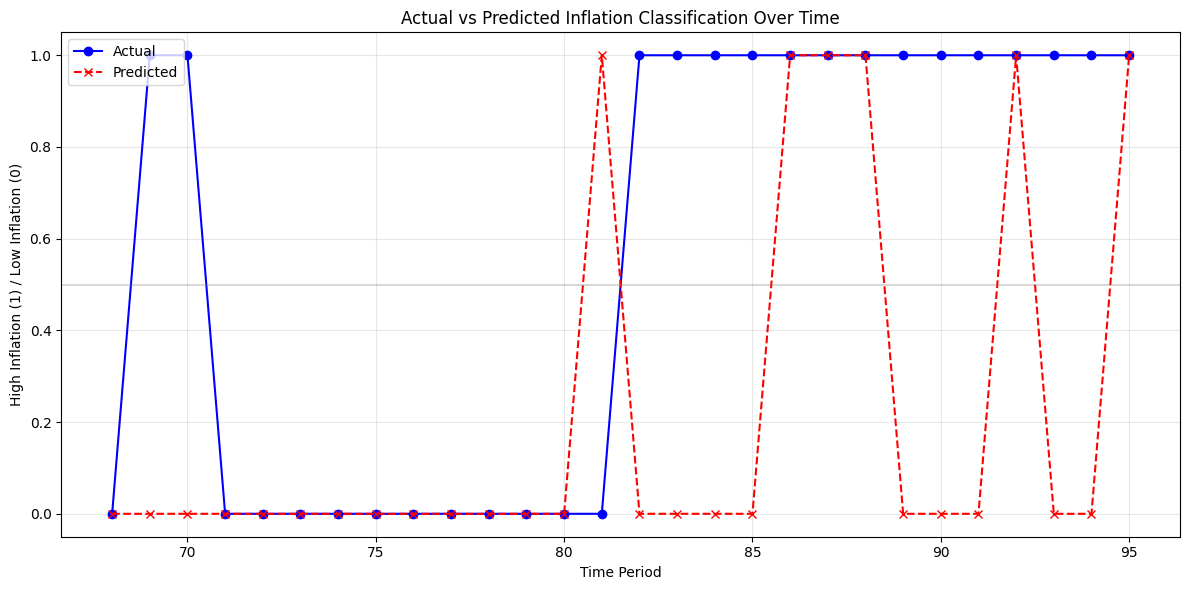

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, roc_auc_score, auc,
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)
import matplotlib.pyplot as plt

# Step 1: Prepare your data
# Assuming you already have your yuan dataframe with CPI values

# Create a binary target variable (e.g., high inflation vs. low inflation)
# For example, classify periods with CPI growth > median as 1, otherwise 0
yuan['cpi_change'] = yuan['cpi'].diff()
yuan['high_inflation'] = (yuan['cpi_change'] > yuan['cpi_change'].median()).astype(int)

# Drop NaN values that result from differencing
yuan = yuan.dropna()

# Define features and target
features = ['total_unrest', 'disaster', 'nominal', 'pop']
X = yuan[features]
y = yuan['high_inflation']

# Step 2: Split the data consistently
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=False  # Keep time order with shuffle=False
)

# Print shapes to verify consistency
print("Training shapes:", X_train.shape, y_train.shape)
print("Testing shapes:", X_test.shape, y_test.shape)

# Step 3: Scale features properly
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames to preserve feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Step 4: Train the logistic regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Step 5: Make predictions
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)

# Print basic metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 6: Feature Importance Plot
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(lr_model.coef_[0])
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance - Logistic Regression')
plt.tight_layout()
plt.show()

# Step 7: Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Low Inflation', 'High Inflation'])
plt.yticks([0, 1], ['Low Inflation', 'High Inflation'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add text annotations in the cells
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
                
plt.tight_layout()
plt.show()

# Step 8: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Step 9: Time Series Plot of Actual vs Predicted
plt.figure(figsize=(12, 6))
timeline = X_test.index
plt.plot(timeline, y_test, 'b-', label='Actual', marker='o')
plt.plot(timeline, y_pred, 'r--', label='Predicted', marker='x')
plt.axhline(y=0.5, color='gray', linestyle='-', alpha=0.3)
plt.ylabel('High Inflation (1) / Low Inflation (0)')
plt.xlabel('Time Period')
plt.title('Actual vs Predicted Inflation Classification Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
df_indicators = df
econ_df = economic_indicators
#new column ames
econ_df = econ_df.rename(columns={
    'Unemployment rate (aged 16 and over, seasonally adjusted): %': 'Unemployment_rate',
    '10-year-gilt-yield': '10_year_gilt_yield',
    'CPIH MONTHLY RATE 00: ALL ITEMS 2015=100': 'CPIH',
    'Gross Value Added - Monthly (Index 1dp) :CVM SA': 'GDP',
    'Monthly average Spot exchange rate, Sterling into US$              [a]             XUMAGBD': 'Exchange_rate_USD',
    'Monthly average Spot exchange rates, Sterling into Euro              [a]             XUMASER': 'Exchange_rate_EUR'
})

#convert dates to datetime
df['Date'] = pd.to_datetime(df['Date'])
econ_df['Date'] = pd.to_datetime(econ_df['Date'])

#  monthly period columns
df['event_month'] = df['Date'].dt.to_period('M')
econ_df['year_month'] = econ_df['Date'].dt.to_period('M')

#Calculate prior 3 months for each event
df['prior_months'] = df['event_month'].apply(lambda m: [m - i for i in range(1, 4)])

#Explode and merge
df_combined = df.explode('prior_months')
merged = df_combined.merge(
    econ_df,
    left_on='prior_months',
    right_on='year_month',
    how='left'
)
#sql techniques
print(df_combined.head(10)) 
indicators = ['GDP', 'Unemployment_rate', '10_year_gilt_yield', 'CPIH', 'CCI', 'Exchange_rate_USD']
averages = merged.groupby(merged.index)[indicators].mean()
averages.columns = [f'{col}_3m_avg' for col in averages.columns]


final_df = df.join(averages)
final_df.drop(columns=['event_month', 'prior_months'], inplace=True)

print("the final dataframe is:")
print(final_df.head(10))

print(final_df.columns)

        Date  Rate  rate_change time_diff  time_diff_days event_month  \
0 1997-05-06  6.25            1       NaT             NaN     1997-05   
0 1997-05-06  6.25            1       NaT             NaN     1997-05   
0 1997-05-06  6.25            1       NaT             NaN     1997-05   
1 1997-06-06  6.50            1   31 days            31.0     1997-06   
1 1997-06-06  6.50            1   31 days            31.0     1997-06   
1 1997-06-06  6.50            1   31 days            31.0     1997-06   
2 1997-07-10  6.75            1   34 days            34.0     1997-07   
2 1997-07-10  6.75            1   34 days            34.0     1997-07   
2 1997-07-10  6.75            1   34 days            34.0     1997-07   
3 1997-08-07  7.00            1   28 days            28.0     1997-08   

  prior_months  
0      1997-04  
0      1997-03  
0      1997-02  
1      1997-05  
1      1997-04  
1      1997-03  
2      1997-06  
2      1997-05  
2      1997-04  
3      1997-07  
the final

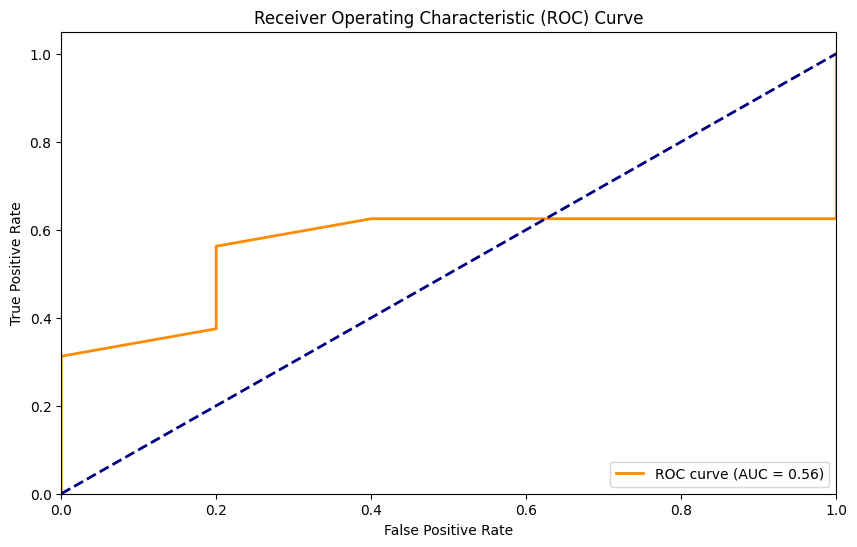

Model Evaluation Metrics:

Classification Report:
              precision    recall  f1-score   support

          -1       0.24      1.00      0.38         5
           1       0.00      0.00      0.00        16

    accuracy                           0.24        21
   macro avg       0.12      0.50      0.19        21
weighted avg       0.06      0.24      0.09        21



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

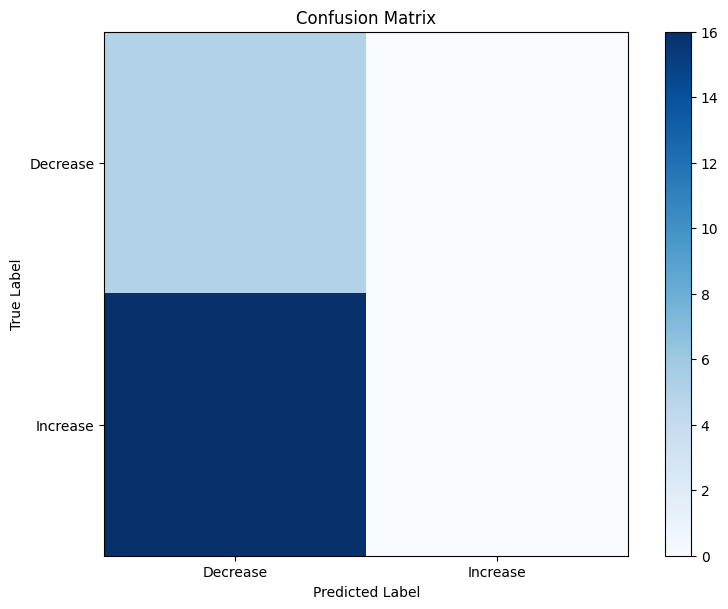

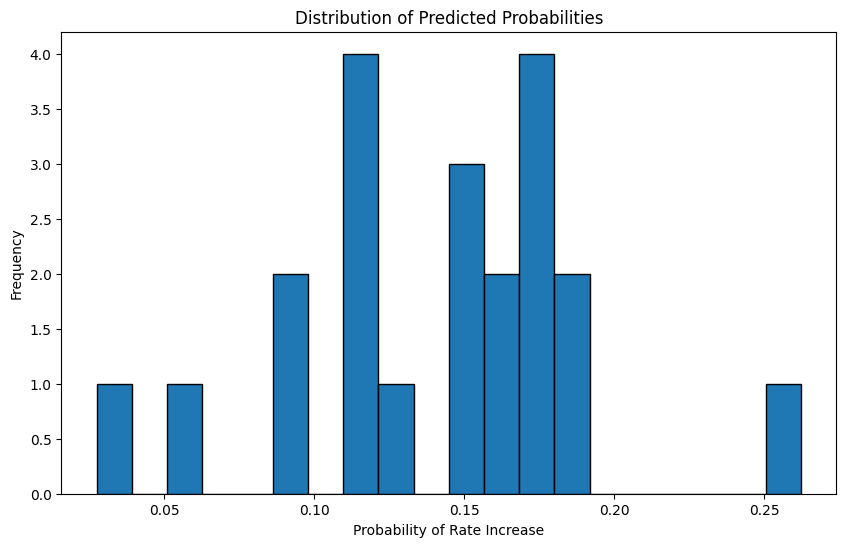


Sample Probability Predictions:
Actual: 1, Predicted Probability of Rate Increase: 0.0542
Actual: 1, Predicted Probability of Rate Increase: 0.0275
Actual: -1, Predicted Probability of Rate Increase: 0.1260
Actual: -1, Predicted Probability of Rate Increase: 0.1108
Actual: 1, Predicted Probability of Rate Increase: 0.0909
Actual: 1, Predicted Probability of Rate Increase: 0.1551
Actual: 1, Predicted Probability of Rate Increase: 0.2623
Actual: 1, Predicted Probability of Rate Increase: 0.1680
Actual: 1, Predicted Probability of Rate Increase: 0.1773
Actual: 1, Predicted Probability of Rate Increase: 0.0909

Feature Importance:
GDP_3m_avg: 0.8699
10_year_gilt_yield_3m_avg: 0.8190
Unemployment_rate_3m_avg: 0.3419
Exchange_rate_USD_3m_avg: 0.2756
CCI_3m_avg: 0.1418
CPIH_3m_avg: 0.1369


In [ ]:
from sklearn.linear_model import LogisticRegression #imports werent working
from sklearn.metrics import (
    roc_curve, 
    roc_auc_score, 
    precision_recall_curve, 
    average_precision_score,
    confusion_matrix, 
    classification_report
)

#features from the previous model
features = [
    'GDP_3m_avg', 
    'Unemployment_rate_3m_avg', 
    '10_year_gilt_yield_3m_avg', 
    'CPIH_3m_avg', 
    'CCI_3m_avg', 
    'Exchange_rate_USD_3m_avg'
]

#predicting rate change
X = final_df[features]
y = final_df['rate_change']


df_sorted = final_df.sort_values('Date')
split_index = int(len(df_sorted) * 0.7)


X_train = df_sorted.iloc[:split_index][features]
X_test = df_sorted.iloc[split_index:][features]
y_train = df_sorted.iloc[:split_index]['rate_change']
y_test = df_sorted.iloc[split_index:]['rate_change']

#scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

#predict probabilities
y_pred_proba = lr_model.predict_proba(X_test_scaled)
y_pred = lr_model.predict(X_test_scaled)

#roc curve
plt.figure(figsize=(10, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()

#model evaluation metrics
print("Model Evaluation Metrics:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Decrease', 'Increase'])
plt.yticks(tick_marks, ['Decrease', 'Increase'])



plt.tight_layout()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')
plt.show()

#Feature Importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': np.abs(lr_model.coef_[0])
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance in Predicting Rate Change')
plt.xlabel('Features')
plt.ylabel('Absolute Coefficient Value')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.close()

#probability distribution
plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba[:, 1], bins=20, edgecolor='black')
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Probability of Rate Increase')
plt.ylabel('Frequency')
plt.savefig('probability_distribution.png')
plt.show()

# Print out  10 probability predictions
print("\nSample Probability Predictions:")
for i, (actual, prob) in enumerate(zip(y_test, y_pred_proba[:, 1]), 1):
    if i <= 10:  # Print first 10 predictions
        print(f"Actual: {actual}, Predicted Probability of Rate Increase: {prob:.4f}")


prob_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted_Probability': y_pred_proba[:, 1]
})
prob_df.to_csv('rate_change_probabilities.csv', index=False)

# Detailed Feature Importance Print
print("\nFeature Importance:")
for _, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")